Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [118]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
import time
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [119]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [120]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


In [121]:
text[:100]

' anarchism originated as a term of abuse first used against early working class radicals including t'

Create a small validation set.

In [122]:
gg = ['', '']
hh = ['a', 'b']
ff = [pp for pp in zip(gg, hh)]

In [123]:
[''.join(fff) for fff in ff]

['a', 'b']

In [124]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [125]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


In [126]:
first_letter

97

Function to generate a training batch for the LSTM model.

In [127]:
batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
['ists advoca', 'ary governm', 'hes nat

In [128]:
len(batches2string([train_batches._last_batch]))

64

In [129]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

In [130]:
rr = random_distribution()
rr

array([[ 0.0661837 ,  0.0475739 ,  0.0540917 ,  0.00676769,  0.03421855,
         0.05467934,  0.06173142,  0.05129745,  0.04791489,  0.05760559,
         0.05356365,  0.00867265,  0.03802682,  0.01483223,  0.01175861,
         0.01940822,  0.01240371,  0.02609507,  0.0393762 ,  0.06564697,
         0.02527978,  0.0568716 ,  0.06339263,  0.01262851,  0.02988232,
         0.03771725,  0.00237955]])

In [131]:
np.sum(rr)

0.99999999999999978

In [132]:
sample(rr)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

In [133]:
characters(sample(rr))[0]

'a'

In [134]:
random.uniform(0, 1)

0.9340813267961147

Simple LSTM Model.

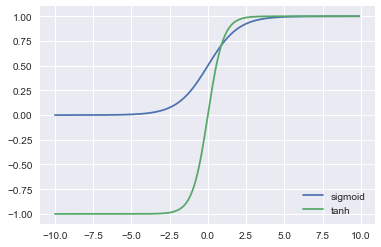

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("darkgrid")

import math

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

xx = np.arange(-10, 10, 0.1)
ysigmoid = sigmoid(xx)
ytanh = np.tanh(xx)

plt.plot(
    xx,
    ysigmoid,
    label='sigmoid'
)

plt.plot(
    xx,
    ytanh,
    label='tanh'
)

plt.legend(loc='lower right')
plt.show()

In [136]:
num_nodes = 64

start = time.time()

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, axis=0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, axis=0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  # gradient clipping: solve gradient exploding
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))
    
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          # randomly sample one character, say, sentence = 'j'
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            # feed = np.zeros((1, 27))
            # feed[0, np.argmax(prediction, axis=1)] = 1
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      bb = ''
      ss = ''
      for _ in range(valid_size):
        b = valid_batches.next()
        bb += characters(b[0])[0]
        predictions = sample_prediction.eval({sample_input: b[0]})
        ss += characters(predictions)[0]
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      # print('bb: %s' % bb)
      # print('ss: %s' % ss)
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
    
end = time.time()
print('Time elapsed: %s' % str(end - start))

Initialized
Average loss at step 0: 3.294078 learning rate: 10.000000
Minibatch perplexity: 26.95
ocoakielia mpb iluyathoe aarpk bjajanoc rqtwamtbpbesg fcwodie snhy aogzpyhn mkn 
tile pzoilv  bnaerd ufrgroayhcyp arxezeb imyacedbdmiyxs fenarrap yieeaibmefidroz
tsmgmxakiowx exynrvfstragwuig vzpzgeo snenh bijnksrafdhdn  kajzjyidftdp e ml hkr
bbwoy kjsqejxsrveecrdaygxsebejeqa gv db u  medhtpv ecyqnafrcecwxpqoeaiaf q  u fa
xp ueoje  kz dmk p zfnyx  tfrex ndoensbqos uve vtrahmnpexstx gqaw w s  bn   b g 
Validation set perplexity: 20.21
Average loss at step 100: 2.599541 learning rate: 10.000000
Minibatch perplexity: 10.96
Validation set perplexity: 10.42
Average loss at step 200: 2.249368 learning rate: 10.000000
Minibatch perplexity: 8.60
Validation set perplexity: 8.41
Average loss at step 300: 2.090972 learning rate: 10.000000
Minibatch perplexity: 7.38
Validation set perplexity: 7.90
Average loss at step 400: 1.992792 learning rate: 10.000000
Minibatch perplexity: 7.48
Validation set per

Validation set perplexity: 4.27
Average loss at step 4500: 1.614567 learning rate: 10.000000
Minibatch perplexity: 5.02
Validation set perplexity: 4.48
Average loss at step 4600: 1.613301 learning rate: 10.000000
Minibatch perplexity: 4.99
Validation set perplexity: 4.45
Average loss at step 4700: 1.624829 learning rate: 10.000000
Minibatch perplexity: 5.18
Validation set perplexity: 4.26
Average loss at step 4800: 1.624806 learning rate: 10.000000
Minibatch perplexity: 4.34
Validation set perplexity: 4.32
Average loss at step 4900: 1.632690 learning rate: 10.000000
Minibatch perplexity: 5.23
Validation set perplexity: 4.49
Average loss at step 5000: 1.607607 learning rate: 1.000000
Minibatch perplexity: 4.48
a ire and gonriew a an dinvice can been capedi nori not present is work tobou al
ble since to hay maborch this was that would promontion list ruld under what dim
c one six one nine four fover inveske brtho world see general he has bastbajed j
ain of deugis canasy that between in c

In [137]:
prediction

array([[  5.02533019e-01,   2.73057949e-02,   6.79405581e-04,
          2.21753633e-03,   3.54795804e-04,   5.07620722e-02,
          2.63456895e-04,   2.81084329e-04,   2.58585513e-01,
          3.33001763e-02,   5.51691883e-05,   2.01390428e-03,
          8.39690026e-03,   4.82842000e-03,   4.60389740e-04,
          1.84957515e-02,   5.31268353e-03,   1.98875758e-04,
          1.64176265e-04,   4.61695204e-03,   6.53905347e-02,
          6.56637503e-03,   2.22137587e-05,   3.78337177e-03,
          1.33107442e-05,   3.26998206e-03,   1.28061001e-04]], dtype=float32)

In [138]:
np.argmax(prediction, axis=1)

ff = np.zeros((1, 27))
ff[0, np.argmax(prediction, axis=1)] = 1
ff

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [139]:
num_nodes = 64

start = time.time()

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  # ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  # im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  # ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  # fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  # fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  # fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  # cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  # cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  # cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  # ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  # om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  # ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Shared weights: input weights, output weights
  iw = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes * 4], -0.4, 0.4))
  ow = tf.Variable(tf.truncated_normal([num_nodes, num_nodes * 4], -0.4, 0.4))
  bb = tf.Variable(tf.truncated_normal([1, num_nodes * 4]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    ww = tf.matmul(i, iw) + tf.matmul(o, ow) + bb
    i, f, o, c = tf.split(ww, num_or_size_splits=4, axis=1)
    input_gate = tf.sigmoid(i)
    forget_gate = tf.sigmoid(f)
    update = c
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(o)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, axis=0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, axis=0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  # gradient clipping: solve gradient exploding
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))
    
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          # randomly sample one character, say, sentence = 'j'
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            # feed = np.zeros((1, 27))
            # feed[0, np.argmax(prediction, axis=1)] = 1
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      bb = ''
      ss = ''
      for _ in range(valid_size):
        b = valid_batches.next()
        bb += characters(b[0])[0]
        predictions = sample_prediction.eval({sample_input: b[0]})
        ss += characters(predictions)[0]
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      # print('bb: %s' % bb)
      # print('ss: %s' % ss)
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
    
end = time.time()
print('Time elapsed: %s' % str(end - start))

Initialized
Average loss at step 0: 3.342610 learning rate: 10.000000
Minibatch perplexity: 28.29
cr mm e  i     ke ee  em    x  uhohf sr i  xe ic dh br zc ze bs gr dr lreu  db a
d ra  yisrehi eg  bn e   p rb r  ls s  py dj x  x  m i   rc ht d   o ge ea a  s 
pee   xo ai ir   ebaeu  qt re r rq    st ewe cr l  d  yu a  z  e k   tj  x  b  e
na x   o o   f i  lw x  pu jmryt   es eye ne   f    o hbe   t eja foer  ix g  o 
q  ge b  a  dt u  j    y  rd r    x o  faeus ys x g  e  agcxe ny nser  wr ve rs 
Validation set perplexity: 32.51
Average loss at step 100: 2.658170 learning rate: 10.000000
Minibatch perplexity: 11.25
Validation set perplexity: 10.89
Average loss at step 200: 2.331641 learning rate: 10.000000
Minibatch perplexity: 9.49
Validation set perplexity: 9.34
Average loss at step 300: 2.174953 learning rate: 10.000000
Minibatch perplexity: 7.06
Validation set perplexity: 8.66
Average loss at step 400: 2.112345 learning rate: 10.000000
Minibatch perplexity: 8.46
Validation set per

Validation set perplexity: 5.06
Average loss at step 4500: 1.696466 learning rate: 10.000000
Minibatch perplexity: 5.68
Validation set perplexity: 5.26
Average loss at step 4600: 1.683150 learning rate: 10.000000
Minibatch perplexity: 5.82
Validation set perplexity: 5.22
Average loss at step 4700: 1.683567 learning rate: 10.000000
Minibatch perplexity: 4.94
Validation set perplexity: 5.26
Average loss at step 4800: 1.669380 learning rate: 10.000000
Minibatch perplexity: 5.00
Validation set perplexity: 5.14
Average loss at step 4900: 1.674476 learning rate: 10.000000
Minibatch perplexity: 5.27
Validation set perplexity: 4.99
Average loss at step 5000: 1.666260 learning rate: 1.000000
Minibatch perplexity: 5.21
heral and comblor side bolling nore past decorportured to cotorg when logategits
ndert th undernotries fundence and de attended of offeric are somes eiffel weppr
k veland new tame of chingouss be belinel the century eight two which be dinuart
umht somever there garbaor development

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [198]:
half_vocab = string.ascii_lowercase + ' '

vocabularies = [c2 + c1 for c2 in half_vocab for c1 in half_vocab]
      
num_vocab = len(vocabularies)
ones = np.eye(num_vocab)

def to_vocab(ids):
    '''ids should be an numpy array in shape (batch_size, num_vocab)'''

    return [vocabs[idx] for idx in np.argmax(np.matmul(ids, ones), axis=1)]

def to_id(vocabs):
    '''vocabs should be an python array in shape (batch_size, 1)'''
    v = np.zeros((len(vocabs), num_vocab))
    for idx, vocab in enumerate(vocabs):
        v[idx][vocabularies.index(vocab)] = 1
    return v

def characters(probabilities):
    v = np.zeros((batch_size, num_vocab))
    for i, idx in enumerate(np.argmax(probabilities, axis=1)):
        v[i][idx] = 1
    return to_vocab(v)

def batch_to_vocab(batches):
    
    return [list(seq) for seq in zip(*[to_vocab(batch) for batch in batches])]

batch_size = 64
num_unrollings = 10

class BatchGenerator(object):
    
    def __init__(self, text, batch_size, num_unrollings):
        
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()
        
    def _next_batch(self):
        '''Generate a single batch from current cursor position'''
        bigrams = []
        
        for b in range(self._batch_size):
            _c = self._cursor[b]
            bigrams.append(self._text[_c:_c+2])
            self._cursor[b] = (self._cursor[b] + 2) % self._text_size   
        
        return to_id(bigrams)
    
    def next(self):
        '''Generate next array of batches'''
        batches = [self._last_batch]
        
        for unrolling in range(self._num_unrollings):
            batches.append(self._next_batch())
            
        self._last_batch = batches[-1]
        return batches
    
train_batch = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batch = BatchGenerator(valid_text, 1, 1)

num_nodes = 64
num_features = 128

graph = tf.Graph()
with graph.as_default():
    
    iw = tf.Variable(tf.truncated_normal([num_features, num_nodes * 4], -0.4, 0.4))
    ow = tf.Variable(tf.truncated_normal([num_nodes, num_nodes * 4], -0.4, 0.4))
    bb = tf.Variable(tf.truncated_normal([1, num_nodes * 4]))
    
    embeddings = tf.Variable(tf.truncated_normal([num_vocab, num_features]))
    
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    
    w = tf.Variable(tf.truncated_normal([num_nodes, num_vocab], -0.1, 0.1))
    b = tf.Variable(tf.zeros([num_vocab]))
    
    def lstm_cell(i, o, state):
        
        ww = tf.matmul(i, iw) + tf.matmul(o, ow) + bb
        i, f, o, c = tf.split(ww, num_or_size_splits=4, axis=1)
        input_gate = tf.sigmoid(i)
        forget_gate = tf.sigmoid(f)
        update = c
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(o)
        return output_gate * tf.tanh(state), state
    
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size, num_vocab])
        )
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]
    
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        i = tf.matmul(i, embeddings)
        i = tf.nn.dropout(i, keep_prob=0.5)
        output, state = lstm_cell(i, output, state)
        output = tf.nn.dropout(output, keep_prob=0.5)
        outputs.append(output)
        
    with tf.control_dependencies([
        saved_output.assign(output),
        saved_state.assign(state)
    ]):
        logits = tf.nn.xw_plus_b(tf.concat(outputs, axis=0), w, b)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=tf.concat(train_labels, axis=0),
                logits=logits
            )
        )
        
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0,
        global_step,
        5000,
        0.1,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    
    optimizer = optimizer.apply_gradients(
        zip(gradients, v),
        global_step=global_step
    )
    
    train_prediction = tf.nn.softmax(logits)
    
    sample_input = tf.placeholder(tf.float32, shape=[1, num_vocab])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes]))
    )
    
    sample_output, sample_state = lstm_cell(tf.matmul(sample_input, embeddings), saved_sample_output, saved_sample_state)
    with tf.control_dependencies([
        saved_sample_output.assign(sample_output),
        saved_sample_state.assign(sample_state)
    ]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))
        
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batch.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate],
            feed_dict=feed_dict
        )
        mean_loss += l
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            print('Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            mean_loss = 0
            labels = np.concatenate(list(batches[1:]))
            print('Minibatch perplexity: %.2f' % float(np.exp(logprob(predictions, labels))))
            reset_sample_state.run()
            valid_logprob = 0
            bb = ''
            ss = ''
            for _ in range(valid_size):
                b = valid_batch.next()
                bb += characters(b[0])[0]
                predictions = sample_prediction.eval({sample_input: b[0]})
                ss += characters(predictions)[0]
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            print('bb: %s' % bb)
            print('ss: %s' % ss)
            print('Validation set perplexity: %.2f' % float(np.exp(valid_logprob / valid_size)))

Initialized
Average loss at step 0: 6.678227 learning rate: 10.000000
Minibatch perplexity: 794.91
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian soci

Average loss at step 200: 5.126041 learning rate: 10.000000
Minibatch perplexity: 157.20
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 400: 4.837997 learning rate: 10.000000
Minibatch perplexity: 123.07
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 600: 4.681373 learning rate: 10.000000
Minibatch perplexity: 107.66
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 800: 4.621061 learning rate: 10.000000
Minibatch perplexity: 99.61
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 1000: 4.483238 learning rate: 10.000000
Minibatch perplexity: 96.30
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 1200: 4.444152 learning rate: 10.000000
Minibatch perplexity: 82.19
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 1400: 4.424769 learning rate: 10.000000
Minibatch perplexity: 76.31
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 1600: 4.349252 learning rate: 10.000000
Minibatch perplexity: 76.36
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 1800: 4.382850 learning rate: 10.000000
Minibatch perplexity: 78.57
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 2000: 4.337322 learning rate: 10.000000
Minibatch perplexity: 67.98
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 2200: 4.293439 learning rate: 10.000000
Minibatch perplexity: 83.89
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 2400: 4.309905 learning rate: 10.000000
Minibatch perplexity: 71.22
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 2600: 4.285763 learning rate: 10.000000
Minibatch perplexity: 74.72
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 2800: 4.238514 learning rate: 10.000000
Minibatch perplexity: 77.44
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 3000: 4.213734 learning rate: 10.000000
Minibatch perplexity: 52.22
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 3200: 4.154888 learning rate: 10.000000
Minibatch perplexity: 67.29
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 3400: 4.224217 learning rate: 10.000000
Minibatch perplexity: 56.32
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 3600: 4.175850 learning rate: 10.000000
Minibatch perplexity: 56.72
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 3800: 4.197479 learning rate: 10.000000
Minibatch perplexity: 61.01
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 4000: 4.228332 learning rate: 10.000000
Minibatch perplexity: 68.96
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 4200: 4.183301 learning rate: 10.000000
Minibatch perplexity: 73.30
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 4400: 4.141920 learning rate: 10.000000
Minibatch perplexity: 64.89
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 4600: 4.170632 learning rate: 10.000000
Minibatch perplexity: 58.43
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 4800: 4.172595 learning rate: 10.000000
Minibatch perplexity: 70.82
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in pla

Average loss at step 5000: 4.165337 learning rate: 1.000000
Minibatch perplexity: 63.09
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 5200: 4.116496 learning rate: 1.000000
Minibatch perplexity: 65.50
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 5400: 4.150527 learning rate: 1.000000
Minibatch perplexity: 53.39
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 5600: 4.095245 learning rate: 1.000000
Minibatch perplexity: 55.72
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 5800: 4.146507 learning rate: 1.000000
Minibatch perplexity: 52.88
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 6000: 4.120358 learning rate: 1.000000
Minibatch perplexity: 58.46
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 6200: 4.121131 learning rate: 1.000000
Minibatch perplexity: 62.84
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 6400: 4.102313 learning rate: 1.000000
Minibatch perplexity: 60.99
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 6600: 4.090174 learning rate: 1.000000
Minibatch perplexity: 62.97
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 6800: 4.107135 learning rate: 1.000000
Minibatch perplexity: 61.03
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

Average loss at step 7000: 4.106533 learning rate: 1.000000
Minibatch perplexity: 78.12
bb:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in plac

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---